<a href="https://colab.research.google.com/github/Pratch-yani/Face_Shape_Classification/blob/main/7_PREDICT_AND_DEPLOY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project:  Face Shape Classification - Part 7

This notebook loads the model to predict on new data, and saves the model for web interface.

In [181]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Libraries

In [182]:
!pip install mtcnn
import mtcnn
from mtcnn.mtcnn import MTCNN

In [183]:
import os 
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt 
import numpy as np 
import pickle

%matplotlib inline

### Define Functions

In [184]:
def crop_and_resize(image, target_w=224, target_h=224):
    '''this function crop & resize images to target size by keeping aspect ratio'''
    if image.ndim == 2:
        img_h, img_w = image.shape             # for Grayscale will be   img_h, img_w = img.shape
    elif image.ndim == 3:
        img_h, img_w, channels = image.shape   # for RGB will be   img_h, img_w, channels = img.shape
    target_aspect_ratio = target_w/target_h
    input_aspect_ratio = img_w/img_h

    if input_aspect_ratio > target_aspect_ratio:
        resize_w = int(input_aspect_ratio*target_h)
        resize_h = target_h
        img = cv2.resize(image, (resize_w , resize_h))
        crop_left = int((resize_w - target_w)/2)  ## crop left/right equally
        crop_right = crop_left + target_w
        new_img = img[:, crop_left:crop_right]
    if input_aspect_ratio < target_aspect_ratio:
        resize_w = target_w
        resize_h = int(target_w/input_aspect_ratio)
        img = cv2.resize(image, (resize_w , resize_h))
        crop_top = int((resize_h - target_h)/4)   ## crop the top by 1/4 and bottom by 3/4 -- can be changed
        crop_bottom = crop_top + target_h
        new_img = img[crop_top:crop_bottom, :]
    if input_aspect_ratio == target_aspect_ratio:
        new_img = cv2.resize(image, (target_w, target_h))

    return new_img

In [185]:
detector = MTCNN()  # creates detector  

def extract_face(img, target_size=(224,224)):
    '''this functions extract the face from different images by 
    1) finds the facial bounding box
    2) slightly expands top & bottom boundaries to include the whole face
    3) crop into a square shape
    4) resize to target image size for modelling
    5) if the facial bounding box in step 1 is not found, image will be cropped & resized to 224x224 square'''
           
    # 1. detect faces in an image
      
    results = detector.detect_faces(img)
    if results == []:    # if face is not detected, call function to crop & resize by keeping aspect ratio
        new_face = crop_and_resize(img, target_w=224, target_h=224)    
    else:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1+width, y1+height
        face = img[y1:y2, x1:x2]  # this is the face image from the bounding box before expanding bbox

        # 2. expand the top & bottom of bounding box by 10 pixels to ensure it captures the whole face
        adj_h = 10

        #assign value of new y1
        if y1-adj_h <10:
            new_y1=0
        else:
            new_y1 = y1-adj_h

        #assign value of new y2    
        if y1+height+adj_h < img.shape[0]:
            new_y2 = y1+height+adj_h
        else:
            new_y2 = img.shape[0]
        new_height = new_y2 - new_y1

        # 3. crop the image to a square image by setting the width = new_height and expand the box to new width
        adj_w = int((new_height-width)/2)    

        #assign value of new x1
        if x1-adj_w < 0:
            new_x1=0
        else:
            new_x1 = x1-adj_w

        #assign value of new x2
        if x2+adj_w > img.shape[1]:
            new_x2 = img.shape[1]
        else:
            new_x2 = x2+adj_w
        new_face = img[new_y1:new_y2, new_x1:new_x2]  # face-cropped square image based on original resolution

    # 4. resize image to the target pixel size
    sqr_img = cv2.resize(new_face, target_size)   
    return sqr_img


In [207]:
y_label_dict = {0: 'Heart', 1: 'Oblong', 2: 'Oval', 3: 'Round', 4: 'Square'}

def predict_face_shape(img_array):
    '''
    this function reads a single image in the form of an array, 
    and process the image then make predictions.
    '''
    try:
        # first extract the face using bounding box
        face_img = extract_face(img_array)  # call function to extract face with bounding box
        new_img = cv2.cvtColor(face_img,cv2.COLOR_BGR2RGB) # convert to RGB -- use this for display          
        # convert the image for modelling
        test_img = np.array(new_img, dtype=float)
        test_img = test_img/255
        test_img = np.array(test_img).reshape(1, 224, 224, 3)  
        # make predictions
        pred = model.predict(test_img)        
        label = np.argmax(pred,axis=1)
        shape = y_label_dict[label[0]]
        print(f'Your face shape is {shape}')
        pred = np.max(pred)
        print(f'Probability {np.around(pred*100,2)}')
        plt.imshow(new_img)
    except Exception as e:
        print(f'Oops!  Something went wrong.  Please try again.')



### Load saved models for predictions

In [193]:
# Transfer Learning model from VGG-Face

transfer_path = '/content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/saved_models/'
transfer_file = transfer_path + 'vgg16-face-2'
model = tf.keras.models.load_model(transfer_file)

### Load some images for testing

In [199]:
# create path to images in model_testing

test_path = '/content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/data_face_shape/model_testing'
test_files = os.listdir(test_path)

test_img = []

for i in test_files:
    img = os.path.join(test_path,i)
    test_img.append(img)
    


In [200]:
image_list = []
for i, file in enumerate(test_img):
  image_list.append(cv2.imread(os.path.join(test_path,file)))
len(image_list)

8

# Predictions

The images with different angles, cropping, and accessories were tested.

- Most of the images are predicted as 'Round'.  This could be the true label.
- At a straight angle, the model predicted 'Heart'
- With sunglasses, the model predicted 'Oblong'


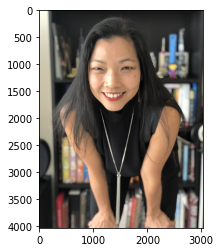

In [205]:
plt.imshow(cv2.cvtColor(image_list[0],cv2.COLOR_BGR2RGB));

Your face shape is Heart
Probability 94.93


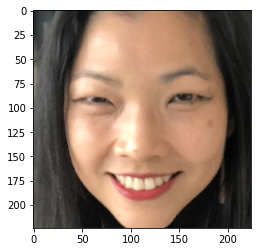

In [208]:
predict_face_shape(image_list[0])

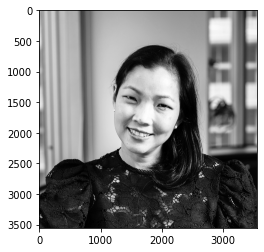

In [209]:
plt.imshow(cv2.cvtColor(image_list[1],cv2.COLOR_BGR2RGB));

Your face shape is Round
Probability 99.99


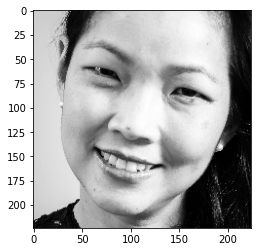

In [210]:
predict_face_shape(image_list[1])

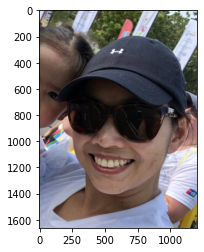

In [212]:
plt.imshow(cv2.cvtColor(image_list[2],cv2.COLOR_BGR2RGB));

Your face shape is Oblong
Probability 99.15


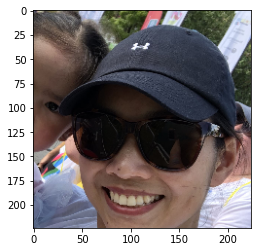

In [213]:
predict_face_shape(image_list[2])

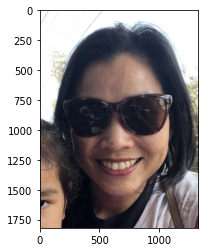

In [214]:
plt.imshow(cv2.cvtColor(image_list[3],cv2.COLOR_BGR2RGB));

Your face shape is Oblong
Probability 96.85


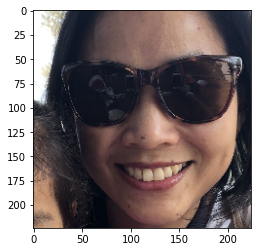

In [215]:
predict_face_shape(image_list[3])

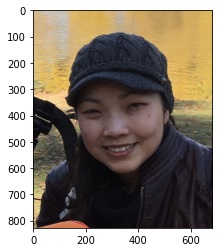

In [216]:
plt.imshow(cv2.cvtColor(image_list[4],cv2.COLOR_BGR2RGB));

Your face shape is Round
Probability 91.76


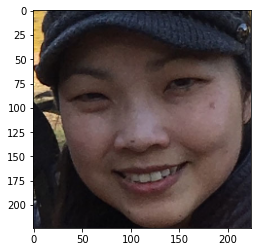

In [217]:
predict_face_shape(image_list[4])

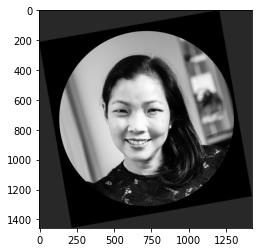

In [218]:
plt.imshow(cv2.cvtColor(image_list[5],cv2.COLOR_BGR2RGB));

Your face shape is Round
Probability 99.29


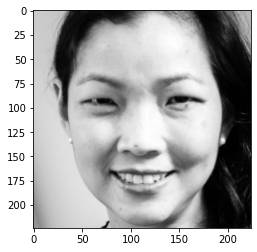

In [219]:
predict_face_shape(image_list[5])

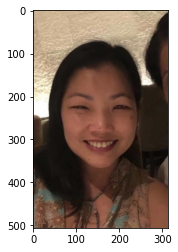

In [220]:
plt.imshow(cv2.cvtColor(image_list[6],cv2.COLOR_BGR2RGB));

Your face shape is Round
Probability 97.14


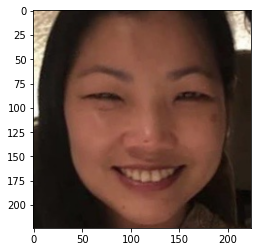

In [221]:
predict_face_shape(image_list[6])

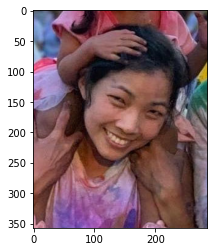

In [222]:
plt.imshow(cv2.cvtColor(image_list[7],cv2.COLOR_BGR2RGB));

Your face shape is Round
Probability 94.84


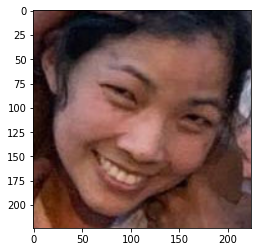

In [223]:
predict_face_shape(image_list[7])

## Conclusion & Key Learning:

The CNN models are suitable for image classification as it trains well with fewer parameter when compared to Fully Connected model. 

Key learning:
- Image pre-process (specifically the bounding box) helps the model train better especially with limited dataset (4000 training images).
- Transfer Learning with the weights trained on larger datasets (2.6 million images) can help improve the accuracy of training as well as the speed.  
- Oval shape is harder to predict with misclassification in different classes.  
- The model performs better on images where the bounding box can be easily detected, however does not predict well on images that the full face cannot be detected (i.e. circle frame, or book club).  